# Royalty Prediction per Artist using LSTM
## Master's Thesis in Data Science
### Autor: Florencia Federico
This analysis applies a LSTM model, including exogenous variables such as social media followers and sentiment.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

file_git = 'https://raw.githubusercontent.com/florfede/royalty-forecasting-timeseries/refs/heads/main/data/dataset.csv'
df = pd.read_csv(file_git)
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.head()

,artist_id,date,royalties,instagram_followers,twitter_followers,track_release,sentiment,mentions_followers,num_posts,num_comments,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_mentions_followers_3m,month
0,436lvfnz,2022-07-01,94291.905,5250688,643908,1,0.649123,26326461,3,57,94291.90500,0.00000,0,0,1,0.649123,26326461,7
1,436lvfnz,2022-08-01,90967.300,5283706,647332,0,0.493088,26326461,7,217,92629.60250,23347.25170,3424,33018,1,0.571105,52652922,8
2,436lvfnz,2022-09-01,96849.325,5316966,648728,1,0.703297,0,5,91,94036.17667,33139.07363,1396,33260,2,0.615169,52652922,9
3,436lvfnz,2022-10-01,94944.180,5346661,649390,0,0.548611,50734,5,144,94263.17750,41478.03735,662,29695,2,0.581665,26377195,10
4,436lvfnz,2022-11-01,93308.900,5403544,649732,1,0.557554,26326461,10,278,94072.32200,58780.37927,342,56883,3,0.603154,26377195,11


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm.notebook import tqdm

def create_sequences(X, y, lookback=3):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

results = []
predictions_output = []

for artist_id, group in tqdm(df.groupby("artist_id")):
    group = group.sort_values("date")
    if len(group) < 15:
        continue

    features = [
        "instagram_followers", "twitter_followers", "track_release", "sentiment",
        "mentions_followers", "num_posts", "num_comments", "mean_royalties_6m",
        "std_instagram_followers_6m", "growth_twitter_followers", "growth_instagram_followers",
        "sum_track_releases_6m", "mean_sentiment_3m", "sum_mentions_followers_3m", "month"
    ]
    target = "royalties"

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(group[features])
    y_scaled = scaler_y.fit_transform(group[[target]])

    lookback = 3
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback)
    if len(X_seq) < 5:
        continue

    train_size = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(lookback, len(features))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, verbose=0)

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_inv = scaler_y.inverse_transform(y_test)

    mse = mean_squared_error(y_test_inv, y_pred)
    mae = mean_absolute_error(y_test_inv, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred)

    results.append({
        "Artist ID": artist_id,
        "Model": "LSTM",
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

    dates = group['date'].values[lookback+train_size:]
    for i in range(len(y_pred)):
        predictions_output.append({
            "artist_id": artist_id,
            "date": dates[i],
            "royalties_actual": y_test_inv[i][0],
            "royalties_predicted": y_pred[i][0],
            "model": "LSTM"
        })


  0%|          | 0/15 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [4]:
df_results = pd.DataFrame(results)
df_results.to_csv("lstm_metrics_per_artist.csv", index=False)

df_preds = pd.DataFrame(predictions_output)
# df_preds.to_csv("lstm_predictions_for_powerbi.csv", index=False)

df_results.head()

,Artist ID,Model,MSE,MAE,RMSE,MAPE
0,436lvfnz,LSTM,5.566938e+08,20155.637813,23594.360225,0.117764
1,5jwhbt0o,LSTM,1.056446e+07,3100.173333,3250.301124,0.257382
2,5t4iv6o3,LSTM,2.801294e+09,43416.832292,52927.254936,0.121053
3,65m1vtnc,LSTM,3.169416e+09,47309.830937,56297.567933,0.069025
4,67gc5xm9,LSTM,3.440019e+09,50853.257969,58651.673089,0.120507


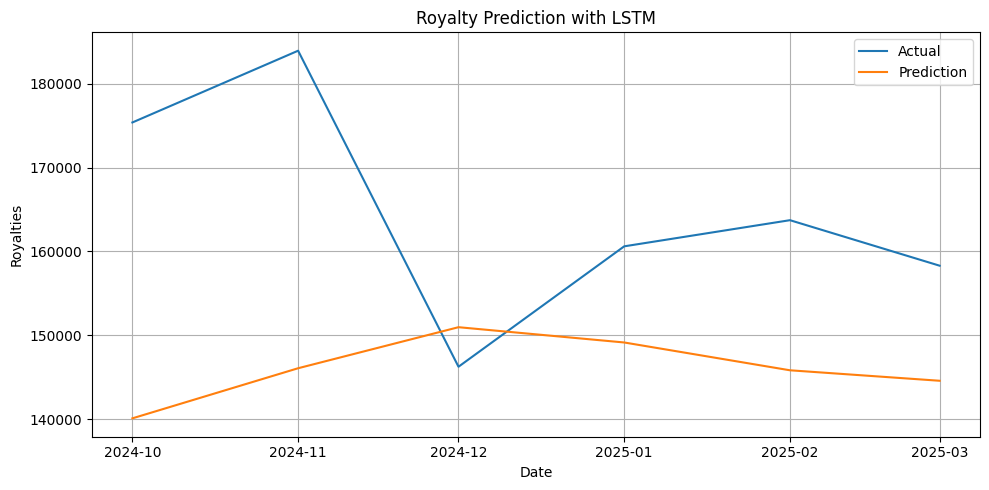

In [5]:
import matplotlib.pyplot as plt

example = df_preds[df_preds["artist_id"] == df_preds["artist_id"].unique()[0]]
plt.figure(figsize=(10,5))
plt.plot(example["date"], example["royalties_actual"], label="Actual")
plt.plot(example["date"], example["royalties_predicted"], label="Prediction")
plt.title("Royalty Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Royalties")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Forecast

Like XGBoost, LSTM does not "know" the future.
To predict more than one month ahead, we need to perform a rolling forecast:
predict the next month, use that prediction as input, and repeat the process.

Additionally, data needs to be scaled for LSTM, and we typically use MinMaxScaler for that.

In [6]:
def forecast_lstm_per_artist(df, artist_id, steps=6):
    """
    Trains an LSTM model per artist and performs a 6-month rolling forecast.

    Parameters:
    - df: DataFrame
    - artist_id: Artist ID
    - steps: Number of months to forecast

    Returns:
    - forecast_df: DataFrame with predictions
    - fig: Plot
    """
    # Filter artist
    df_artist = df[df['artist_id'] == artist_id].copy()
    df_artist = df_artist.sort_values('date')

    # Ensure proper datetime format
    df_artist['date'] = pd.to_datetime(df_artist['date'])
    df_artist = df_artist.set_index('date').asfreq('MS')

    # Scale royalties
    scaler = MinMaxScaler()
    scaled_royalties = scaler.fit_transform(df_artist[['royalties']])

    # Create X, y sequences
    X = []
    y = []
    for i in range(1, len(scaled_royalties)):
        X.append(scaled_royalties[i - 1])
        y.append(scaled_royalties[i])
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], 1, X.shape[1]))  # (samples, time_steps, features)

    # Build and train model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # Rolling forecast
    forecasts = []
    last_input = scaled_royalties[-1].reshape((1, 1, 1))
    last_date = df_artist.index[-1]

    for _ in range(steps):
        pred_scaled = model.predict(last_input, verbose=0)
        pred_royalties = scaler.inverse_transform(pred_scaled)[0][0]

        pred_date = last_date + pd.DateOffset(months=1)

        forecasts.append({
            'artist_id': artist_id,
            'prediction_date': pred_date,
            'royalties_forecast': pred_royalties
        })

        # Update input for next prediction
        last_input = pred_scaled.reshape((1, 1, 1))
        last_date = pred_date

    forecast_df = pd.DataFrame(forecasts)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    df_artist['royalties'].plot(ax=ax, label='Historical')
    forecast_df.set_index('prediction_date')['royalties_forecast'].plot(ax=ax, label='Forecast', color='orange')
    ax.set_title(f'LSTM Forecast - Artist {artist_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Royalties')
    ax.legend()
    plt.tight_layout()
    plt.close(fig)

    return forecast_df, fig


In [7]:
# List of artists
artist_list = df['artist_id'].unique()

# Store results
forecast_list = []
figure_list = []

# Loop
for artist_id in artist_list:
    forecast_df, figure = forecast_lstm_per_artist(df, artist_id, steps=6)
    forecast_list.append(forecast_df)
    figure_list.append((artist_id, figure))

# Consolidate forecasts
consolidated_forecasts_df = pd.concat(forecast_list, ignore_index=True)


Forecast chart for artist 436lvfnz


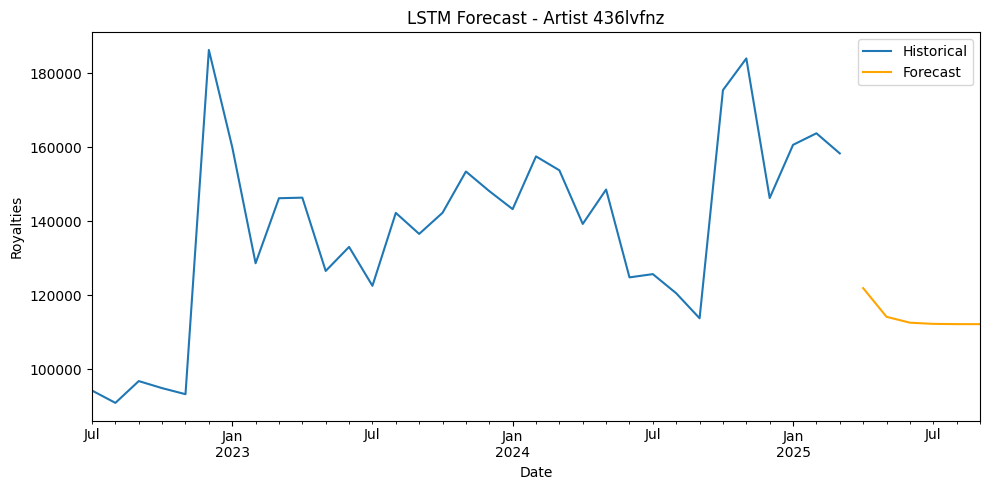

Forecast chart for artist 5jwhbt0o


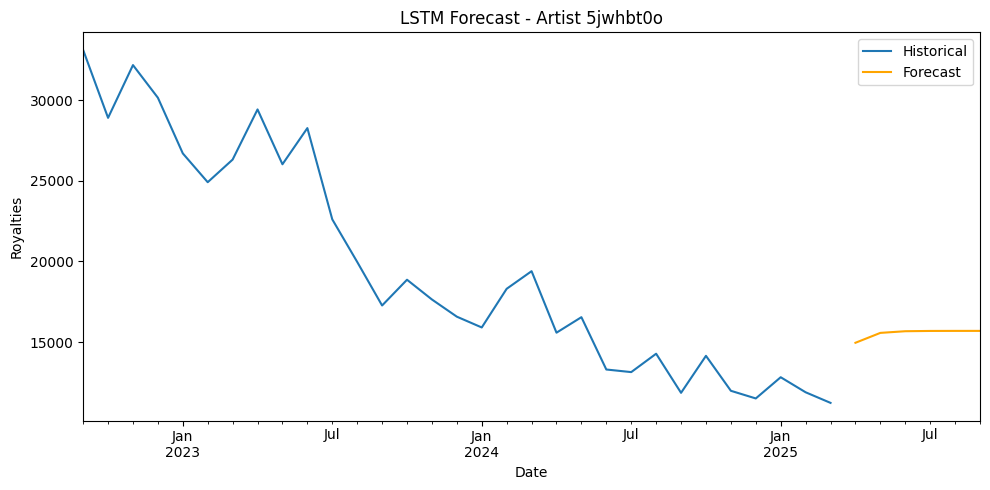

Forecast chart for artist 5t4iv6o3


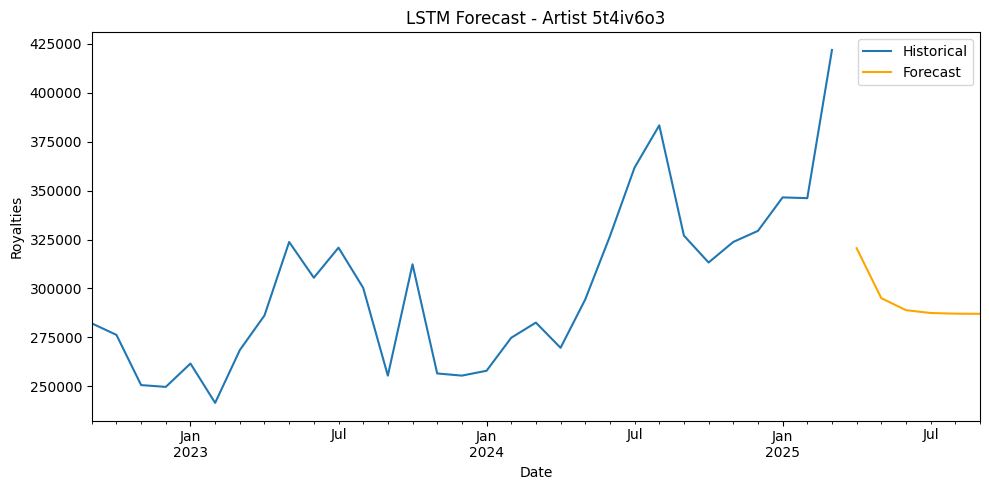

Forecast chart for artist 65m1vtnc


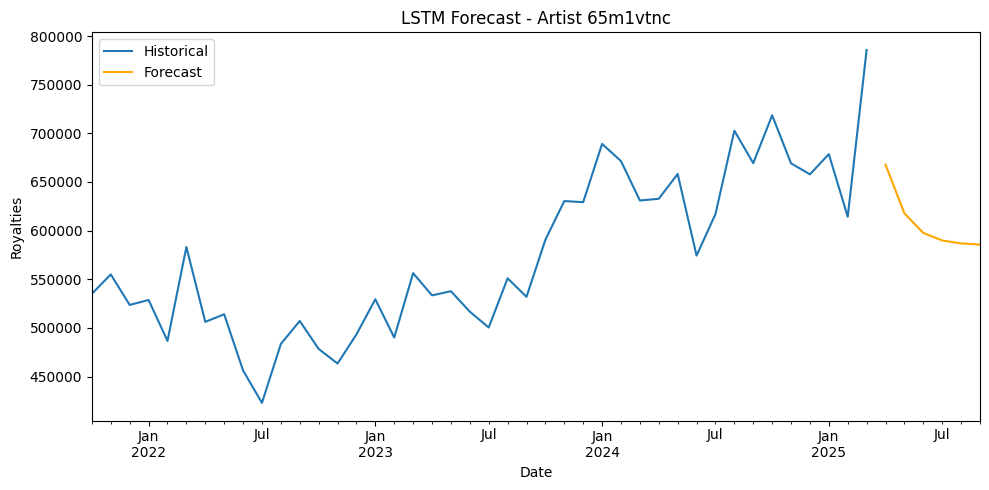

Forecast chart for artist 67gc5xm9


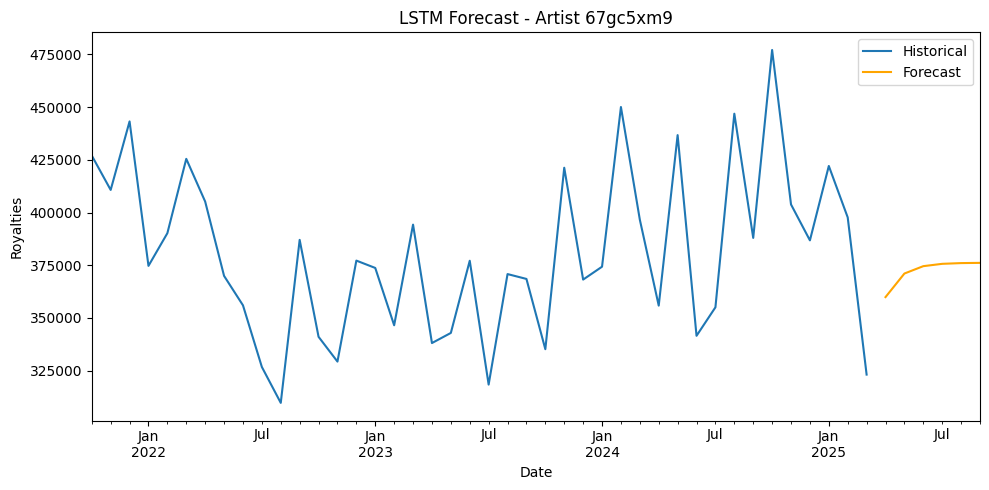

Forecast chart for artist 6ygz70qs


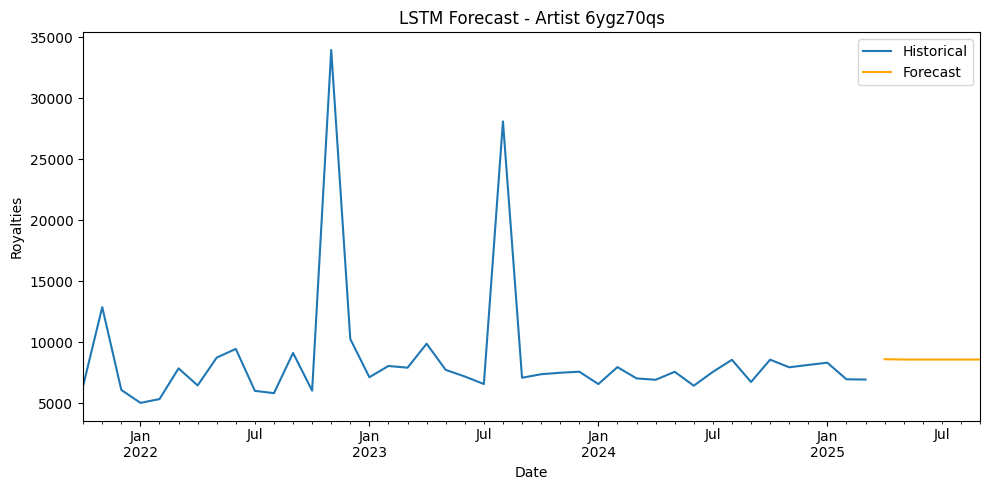

Forecast chart for artist al0gcvtm


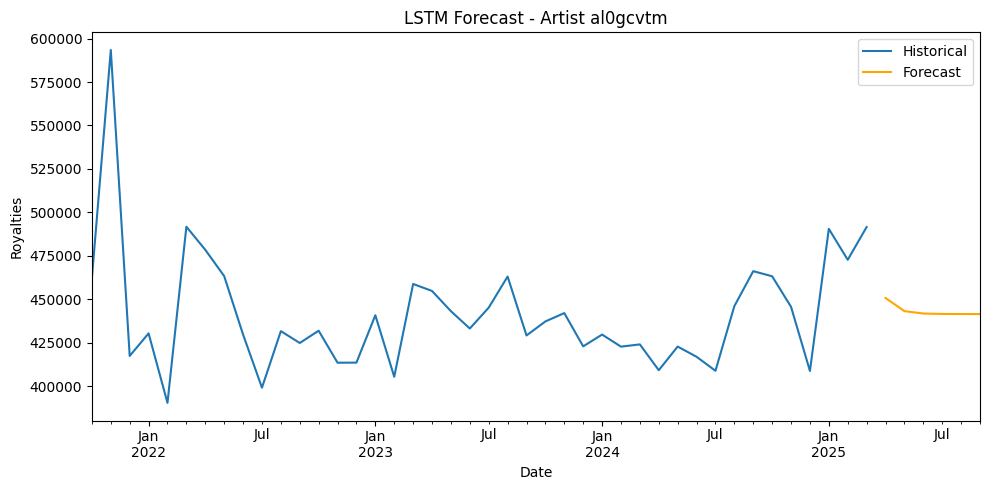

Forecast chart for artist awrkf92m


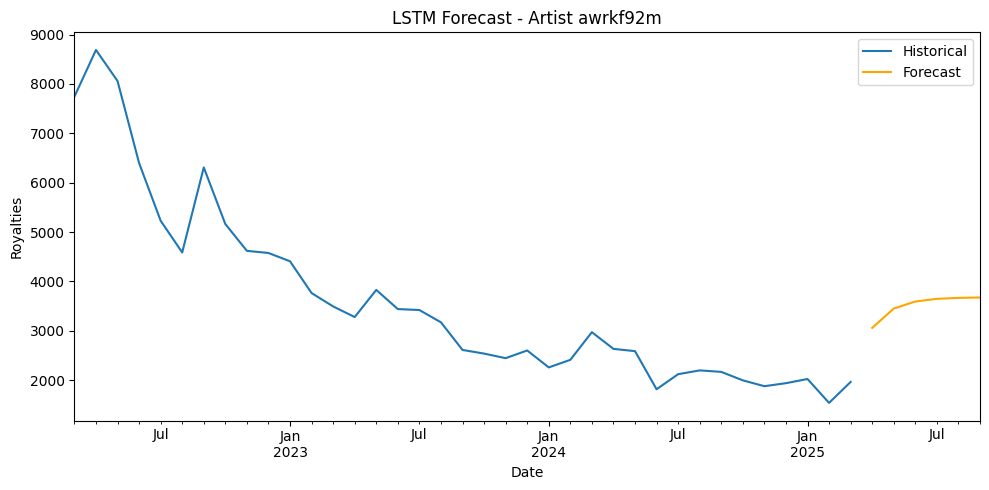

Forecast chart for artist bpgx7194


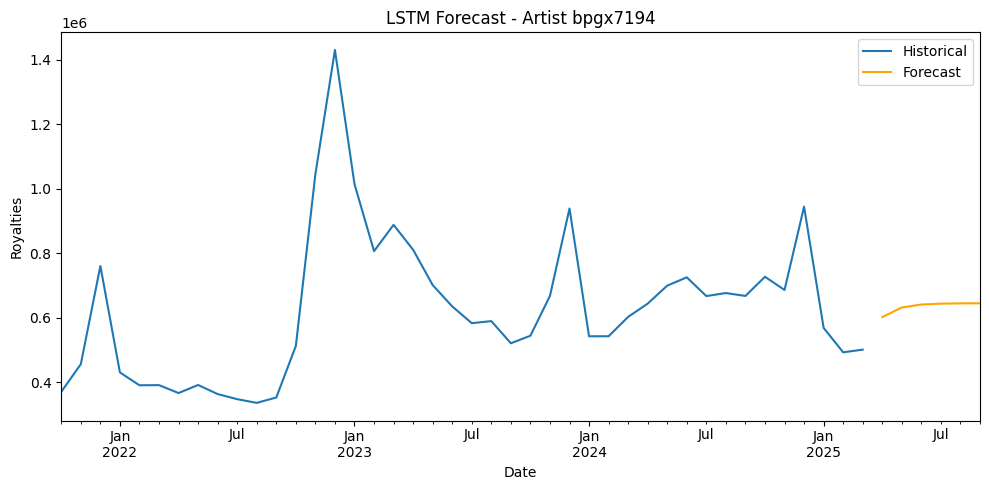

Forecast chart for artist hfiatnv8


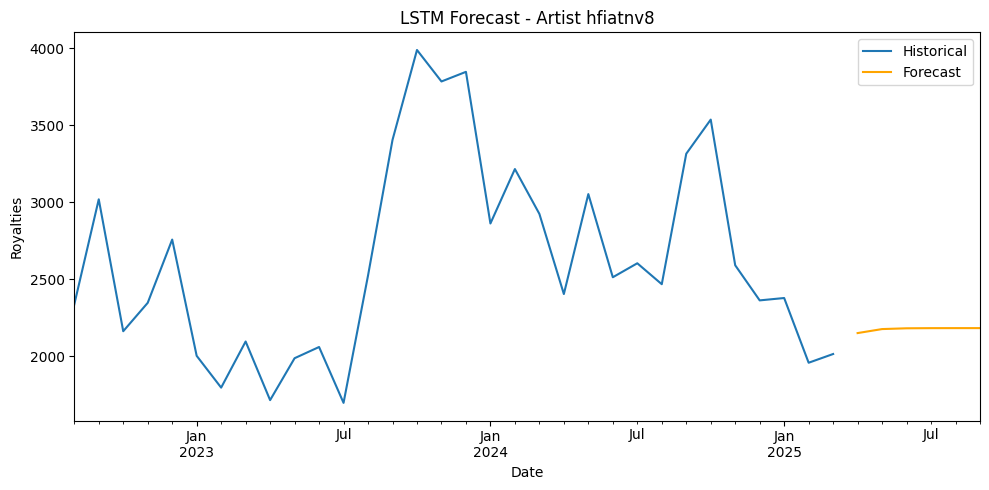

Forecast chart for artist jla6nu3p


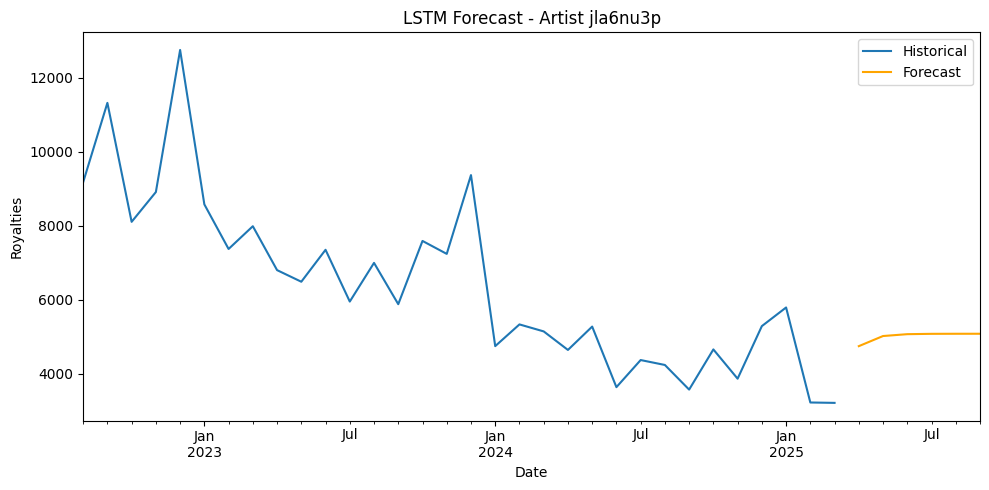

Forecast chart for artist k74pw1av


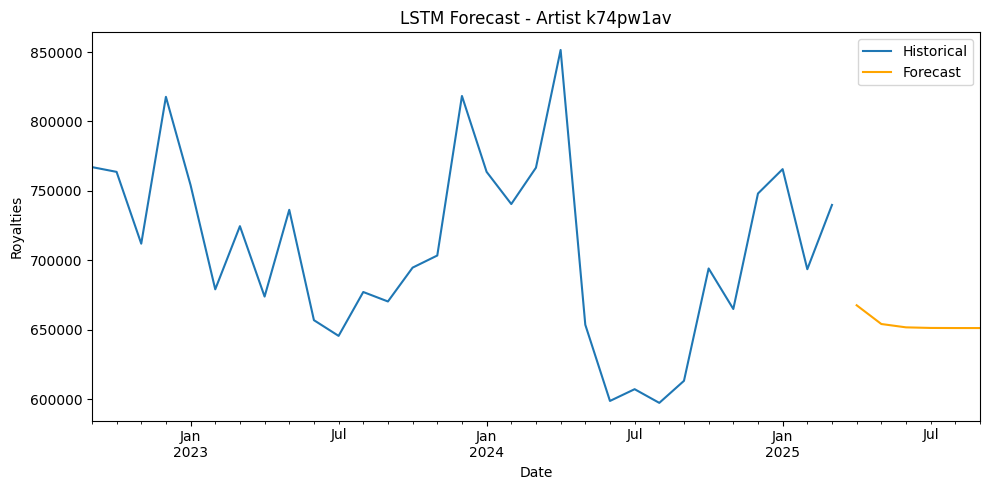

Forecast chart for artist kcw3uapo


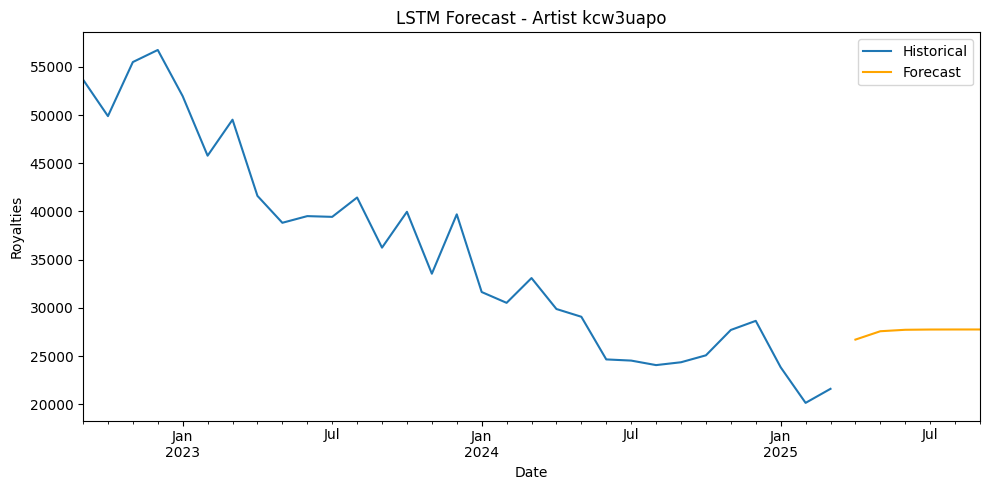

Forecast chart for artist pymr5w10


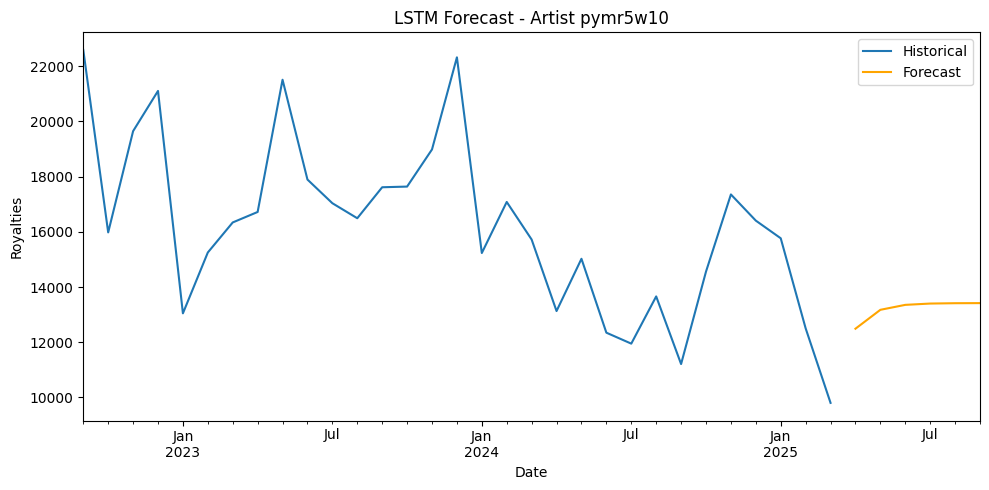

Forecast chart for artist r976ytqo


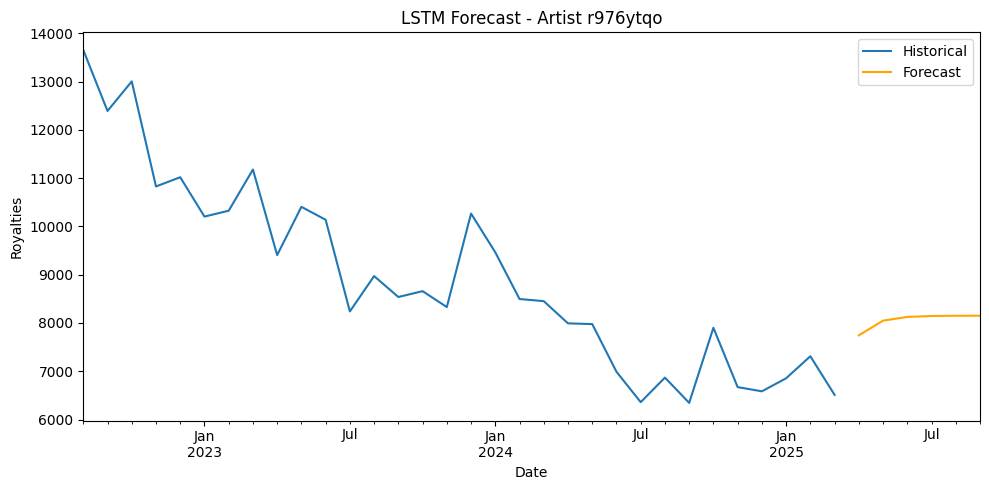

In [8]:
# Display forecast charts
for artist_id, figure in figure_list:
    print(f"Forecast chart for artist {artist_id}")
    display(figure)
